# retail_sales_forecast

## Imports

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_selector,make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler,OneHotEncoder,FunctionTransformer
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
pd.set_option("display.float_format", "{:,.2f}".format)

## Importação da Base

In [3]:
df_data = pd.read_parquet('df_data.parquet')

In [4]:
print(f'shape: {df_data.shape}')
display(df_data.head(0))
print(df_data.info())

shape: (3000888, 12)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,holiday,dcoilwtico


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  float64
 6   city         object 
 7   state        object 
 8   type         object 
 9   cluster      object 
 10  holiday      float64
 11  dcoilwtico   float64
dtypes: float64(4), int64(2), object(6)
memory usage: 274.7+ MB
None


In [5]:
df_data['chave'] = df_data['store_nbr'].astype('str') + df_data['family']
df_data['holiday'] = df_data['holiday'].astype('str')

In [6]:
# Number of sequences:
df_sequences = df_data['chave'].drop_duplicates()
n_sequences = df_sequences.count()
print(f'n_sequences: {n_sequences}')

n_sequences: 1782


In [7]:
# Number of observations:
n_observations = df_data.groupby('chave')[['sales']].count()
print(f'chave com quantidade de observações diferentes de {n_observations.iloc[0,0]}:')
display(n_observations[n_observations['sales']!=n_observations.iloc[0,0]])
n_observations = n_observations.iloc[0,0]
print('\n')
print(f'n_observations: {n_observations}')

chave com quantidade de observações diferentes de 1684:


,sales
chave,




n_observations: 1684


In [8]:
# Number of features:
print(f'columns: {df_data.columns}')
features = ['sales','onpromotion', 'city', 'state', 'type', 'cluster', 'holiday', 'dcoilwtico']
print(f'features: {features}')
n_features = len(features)
print(f'n_features: {n_features}')

columns: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster', 'holiday', 'dcoilwtico', 'chave'],
      dtype='object')
features: ['sales', 'onpromotion', 'city', 'state', 'type', 'cluster', 'holiday', 'dcoilwtico']
n_features: 8


## Seleção de amostras para teste
###### Redução de tempo de processamento para validação de modelo

In [17]:
# Seleção de top n sequencias para teste do modelo:

n = 10
df_sequences = df_data.groupby('chave')[['sales']].sum().sort_values(by='sales', ascending=False).head(n)
df_sequences = df_sequences.reset_index().drop(columns='sales')
df_sequences

,chave
0,44GROCERY I
1,45GROCERY I
2,47GROCERY I
3,46GROCERY I
4,44BEVERAGES
5,3GROCERY I
6,48GROCERY I
7,45BEVERAGES
8,3BEVERAGES
9,49GROCERY I


In [24]:
# Seleção das amostras
for sequence in df_sequences['chave']:
    df_data.loc[df_data['chave'] == sequence, 'chave_aux'] = 'x'

df_data = df_data[df_data['chave_aux'] == 'x']
df_data.drop(columns = 'chave_aux', inplace = True)
print(df_data.shape)

(16840, 13)


## Preprocessamento

In [25]:
# Seleção de features
df_data_input = df_data[features]
df_data_input.shape

(16840, 8)

In [56]:
# Seleção de colunas categóricas e numéricas para preprocessamento
y_col = ['sales']
num_cols = ['onpromotion','dcoilwtico']
cat_cols = ['city', 'state', 'type', 'cluster', 'holiday']

# Criação de transformadores
y_transformer = RobustScaler()
num_transformer = RobustScaler()
cat_transformer = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

# Criação de pipeline de preprocessamento
preproc = make_column_transformer(
    (y_transformer, y_col),
    (num_transformer, num_cols),
    (cat_transformer, cat_cols)
)
preproc

ColumnTransformer(transformers=[('robustscaler-1', RobustScaler(), ['sales']),
                                ('robustscaler-2', RobustScaler(),
                                 ['onpromotion', 'dcoilwtico']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['city', 'state', 'type', 'cluster',
                                  'holiday'])])

In [57]:
# Preprocessamento
preproc.fit(df_data_input)
data_transformed = preproc.transform(df_data_input)
feature_names = preproc.get_feature_names_out()
print(data_transformed.shape)

(16840, 11)


In [58]:
# Retornar com a chave para o dataframe
df_data_transformed = pd.concat([pd.DataFrame(data_transformed, columns = feature_names), df_data[['chave']].reset_index(drop=True)], axis = 1)
print(f'df_data_transformed shape: {df_data_transformed.shape}')
display(df_data_transformed.head(1))

df_data_transformed shape: (16840, 12)


,robustscaler-1__sales,robustscaler-2__onpromotion,robustscaler-2__dcoilwtico,onehotencoder__city_Quito,onehotencoder__state_Pichincha,onehotencoder__type_D,onehotencoder__cluster_11,onehotencoder__cluster_14,onehotencoder__cluster_5,onehotencoder__cluster_8,onehotencoder__holiday_1.0,chave
0,-1.78,-0.25,0.81,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,3BEVERAGES


## X e Y

In [59]:
def sequence_creation(df_data, df_sequences):

    sequences = []
    for sequence in df_sequences['chave']:
        df_sequence_i = df_data[df_data['chave'] == sequence]
        sequence_i = np.array(df_sequence_i.drop(columns = 'chave'))
        sequences.append(sequence_i)

    #X_y= (n_sequences, n_observations, n_features)
    X_y = np.array(sequences)

    return X_y

In [60]:
%%time

# 1º passo: criação do tensor geral
X_y = sequence_creation(df_data_transformed, df_sequences)

print(f'X_y.shape: {X_y.shape}')
assert X_y.dtype == 'float64', 'Deve retornar type == float64'
print(X_y.dtype)

X_y.shape: (10, 1684, 11)
float64
CPU times: user 46.4 ms, sys: 1.69 ms, total: 48.1 ms
Wall time: 46 ms


In [61]:
# 2º passo: divisão de train e test
test_ratio = 0.5
train_split = int(n_observations * (1-test_ratio))
test_split = n_observations - train_split

X_y_train = X_y[:,:train_split,:]
X_y_test = X_y[:,train_split:,:]

print(f'X_y_train.shape: {X_y_train.shape}')
print(f'X_y_test.shape: {X_y_test.shape}')

X_y_train.shape: (10, 842, 11)
X_y_train.shape: (10, 842, 11)


In [62]:
# 3º passo: divisão do train e test em X e y

y_lag = 16

x_train_split = X_y_train.shape[1] - y_lag
x_test_split = X_y_test.shape[1] - y_lag

# Train
X_train = X_y_train[:,:x_train_split,:]
y_train = X_y_train[:,x_train_split:,0]
y_train = np.expand_dims(y_train, axis=-1)


# Test
X_test = X_y_test[:,:x_test_split,:]
y_test = X_y_test[:,x_test_split:,0]
y_test = np.expand_dims(y_test, axis=-1)


print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')


X_train.shape: (10, 826, 11)
y_train.shape: (10, 16, 1)
X_test.shape: (10, 826, 11)
y_test.shape: (10, 16, 1)


## RNN

### Modelo 01

In [154]:
%%time
# 1- RNN Architecture
model = Sequential()
model.add(layers.GRU(units=128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(layers.GRU(units=64, activation='tanh', return_sequences=True))
model.add(layers.GRU(units=64, activation='tanh', return_sequences=True))
model.add(layers.GRU(units=32, activation='tanh'))
model.add(layers.Dense(16, activation="linear"))

# 2- Compilation
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.005)) # very high lr so we can converge with such a small dataset

# Definir EarlyStopping
#early_stopping = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)

# 3- Fit
#history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=32, callbacks=[early_stopping],verbose=1)
history = model.fit(X_train, y_train,epochs=850, verbose = 1)

Epoch 1/850
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.4770
Epoch 2/850
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3486
Epoch 3/850
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3258
Epoch 4/850
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2343
Epoch 5/850
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1787
Epoch 6/850
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1463
Epoch 7/850
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1200
Epoch 8/850
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1104
Epoch 9/850
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0741
Epoch 10/850
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0856
Epoch 11/850
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0699
Epoch 12/850
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0650
Epoch 13/850
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0622
Epoch 14/850
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0569
Epoch 15/850
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0535
Epoch 16/850
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 

In [155]:
y_pred_scaled = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step


In [156]:
y_pred_original = preproc.named_transformers_['robustscaler-1'].inverse_transform(y_pred_scaled)

In [157]:
y_test_original = preproc.named_transformers_['robustscaler-1'].inverse_transform(y_test.reshape(y_test.shape[0],y_test.shape[1]))

In [158]:
from sklearn.metrics import mean_absolute_error
mae_original = mean_absolute_error(y_test_original, y_pred_original)

print(f'Model Mean Absolute Error {mae_original:.4f}')

Model Mean Absolute Error 2989.4480


In [159]:
y_pred_original

array([[ 6629.3267,  7463.028 , 11598.939 , 13642.27  ,  7570.609 ,
         6482.6255,  8241.537 ,  6945.9224,  8656.25  , 12754.734 ,
        14441.208 ,  8627.328 ,  7172.5376,  7633.2046,  6469.012 ,
         7901.301 ],
       [ 6414.494 ,  7321.987 , 11456.087 , 13664.546 ,  7589.9214,
         6581.012 ,  8026.7764,  7011.3413,  8442.243 , 12515.297 ,
        14646.184 ,  8827.576 ,  7240.5073,  7629.983 ,  6550.3867,
         8347.2   ],
       [ 6390.121 ,  7324.262 , 11432.437 , 13652.333 ,  7592.8623,
         6583.162 ,  8001.499 ,  7001.251 ,  8426.008 , 12489.465 ,
        14654.135 ,  8838.337 ,  7252.8643,  7627.6377,  6562.4883,
         8373.92  ],
       [ 6364.0234,  7324.1387, 11387.28  , 13640.474 ,  7588.0864,
         6573.629 ,  7980.407 ,  6983.4175,  8403.038 , 12442.947 ,
        14659.486 ,  8835.309 ,  7262.0703,  7614.671 ,  6559.867 ,
         8378.078 ],
       [ 6655.824 ,  7577.5596, 11622.984 , 13631.71  ,  7573.995 ,
         6394.799 ,  8275.582 , 

In [160]:
y_test_original

array([[ 9934., 10941., 11156.,  8419.,  9346., 12463., 13248.,  8497.,
         8201.,  8062.,  7097.,  9979.,  9391.,  9811.,  8318.,  8123.],
       [11544., 12327., 12494.,  9583., 11562., 14189., 15190., 10574.,
         8693.,  9345.,  8044., 11088.,  9917., 12723.,  9665.,  9287.],
       [12238., 12456., 12263.,  9898., 10026., 12937., 13166.,  8845.,
         7973.,  8580.,  8029., 10297.,  9258., 10110.,  8946.,  9389.],
       [11039., 11574., 10701.,  8086.,  8728., 13244., 14233.,  9189.,
         6828.,  6995.,  6352.,  9934.,  9218., 10557.,  7570.,  7222.],
       [10860., 10808.,  9461.,  7396.,  8620., 12455., 12913.,  8254.,
         6967.,  7679.,  7595.,  9517.,  9624., 10491.,  7322.,  7351.],
       [ 7491.,  8229.,  8761.,  7120.,  8568.,  8532.,  9668.,  7598.,
         6699.,  7285.,  6079.,  7727.,  7167.,  7749.,  7053.,  6955.],
       [10120., 11274.,  9945.,  8031.,  7975., 11786., 14062.,  8040.,
         6443.,  5635.,  5522.,  8547.,  8306.,  9423.,  6

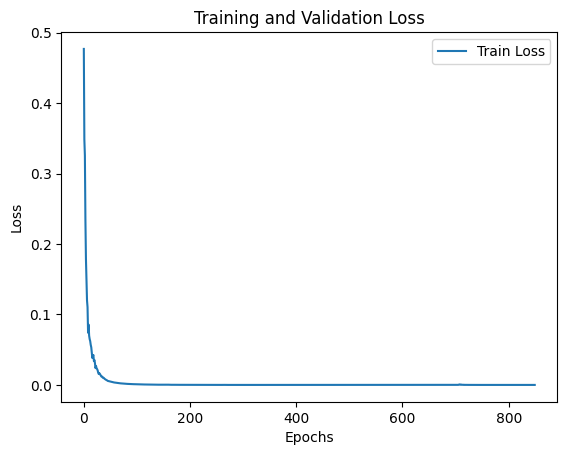

In [161]:

# Plotando a perda no treino e na validação
plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [162]:
min_train_loss = min(history.history['loss'])
print(f"Menor erro de treino (loss): {min_train_loss}")
best_epoch = history.history['loss'].index(min_train_loss) + 1
print(f"Melhor época para validação: {best_epoch}")

Menor erro de treino (loss): 9.469600498440266e-15
Melhor época para validação: 679


In [1]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
rmsle = np.sqrt(mean_squared_log_error(y_test_original, y_pred_original))
print(f"RMSLE na escala original: {rmsle:.2f}")

NameError: name 'np' is not defined

### Modelo 02

In [ ]:
%%time
# 1- RNN Architecture
model_2 = Sequential()
model_2.add(layers.LSTM(units=128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_2.add(layers.LSTM(units=64, activation='tanh', return_sequences=True))
model_2.add(layers.LSTM(units=64, activation='tanh', return_sequences=True))
model_2.add(layers.LSTM(units=32, activation='tanh'))
model_2.add(layers.Dense(16, activation="linear"))

# 2- Compilation
model_2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.005)) # very high lr so we can converge with such a small dataset

# Definir EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)

# 3- Fit
#history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=32, callbacks=[early_stopping],verbose=1)
history_2 = model.fit(X_train, y_train,epochs=850, verbose = 1, callbacks=[early_stopping])

In [ ]:
y_pred_scaled_2 = model_2.predict(X_test)

In [ ]:
y_pred_original_2 = preproc.named_transformers_['robustscaler-1'].inverse_transform(y_pred_scaled)

In [ ]:
y_test_original_2 = preproc.named_transformers_['robustscaler-1'].inverse_transform(y_test.reshape(y_test.shape[0],y_test.shape[1]))

In [ ]:
from sklearn.metrics import mean_absolute_error
mae_original = mean_absolute_error(y_test_original_2, y_pred_original_2)

print(f'Model Mean Absolute Error {mae_original:.4f}')

In [ ]:
y_pred_original_2

In [ ]:
y_test_original_2

In [ ]:
# Plotando a perda no treino e na validação
plt.plot(history_2.history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
min_train_loss = min(history.history['loss'])
print(f"Menor erro de treino (loss): {min_train_loss}")
best_epoch = history.history['loss'].index(min_train_loss) + 1
print(f"Melhor época para validação: {best_epoch}")